In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

DIV_CMAP = sns.diverging_palette(220, 0, as_cmap=True) # DIVERGENT COLOR MAP
sns.set_style("whitegrid")


METRICS_DIR = "../outputs/metrics/proxy_metrics_20220426"

## Compute correlations for individual metrics in DEV set

In [2]:
SPLIT = "dev"
DATASET = "all_datasets"
TARGET_COL = "human_correctness"

DEV_FILEPATH = f"{METRICS_DIR}/{SPLIT}_{DATASET}_metrics.csv.gz"

In [3]:
dev_df = pd.read_csv(DEV_FILEPATH, index_col=0)
print("Read dataset with", len(dev_df), "examples from", DEV_FILEPATH)
print("Data file contains data for:", dev_df.dataset.unique())
dev_df.describe()

Read dataset with 4009 examples from ../outputs/metrics/proxy_metrics_20220426/dev_all_datasets_metrics.csv.gz
Data file contains data for: ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']


,human_correctness_original,human_correctness,exact_match,meteor,rouge1,rouge2,rougeL,rougeLsum,bleurt,bert-score,...,bleu-precision0,bleu-precision1,bleu-precision2,bleu-precision3,precision,recall,f1_score,csi,num_edits,edit_score
count,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,...,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000
mean,2.357238,0.339309,0.024944,0.247296,0.287694,0.107104,0.281029,0.281029,-0.688747,0.882008,...,0.258614,0.093471,0.042008,0.016961,0.258614,0.291364,0.245709,0.169090,4.633076,1.593062
std,1.498841,0.374710,1.579363,0.270958,0.274079,0.209965,0.270506,0.270506,0.762111,0.054886,...,0.291076,0.202191,0.145938,0.089283,0.291076,0.314313,0.258518,0.199534,4.168400,2.703827
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.616384,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.290687,0.847648,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.666667
50%,1.666667,0.166667,0.000000,0.161290,0.250000,0.000000,0.230769,0.230769,-0.831038,0.873768,...,0.166667,0.000000,0.000000,0.000000,0.166667,0.200000,0.181818,0.100000,3.000000,1.000000
75%,3.666667,0.666667,0.000000,0.387427,0.500000,0.111111,0.500000,0.500000,-0.151100,0.910523,...,0.500000,0.000000,0.000000,0.000000,0.500000,0.500000,0.444444,0.285714,6.000000,1.500000
max,5.000000,1.000000,100.000000,0.999624,1.000000,1.000000,1.000000,1.000000,1.200342,1.000011,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,79.000000,79.000000


<AxesSubplot:>

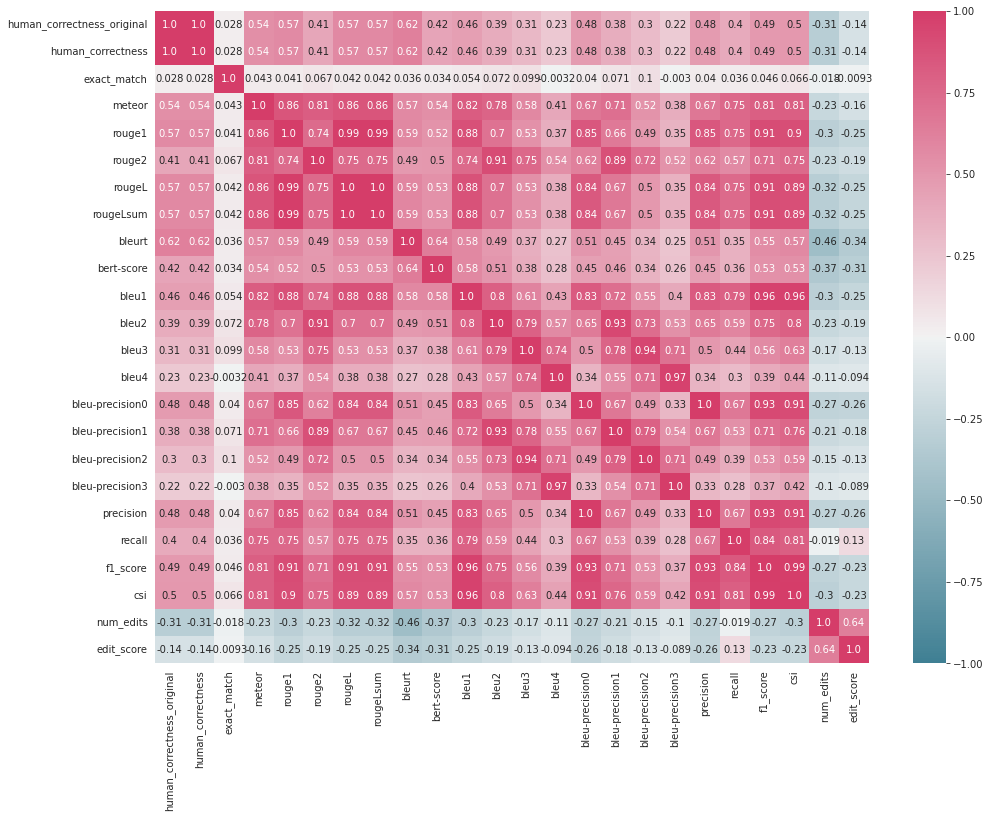

In [4]:
plt.figure(figsize=(16,12))
sns.heatmap(dev_df.corr(), vmin=-1, vmax=1, cmap=DIV_CMAP, annot=True, fmt=".2")

### Determine the metrics distribution

<AxesSubplot:xlabel='csi', ylabel='human_correctness'>

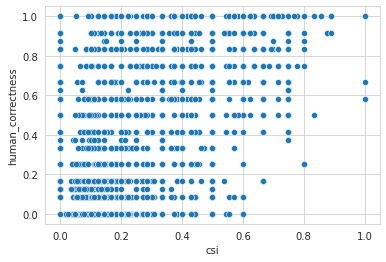

In [5]:
sns.scatterplot(data=dev_df, x="csi", y="human_correctness")

<AxesSubplot:xlabel='f1_score', ylabel='rougeL'>

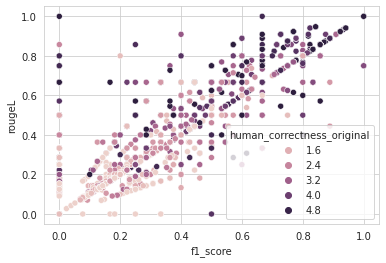

In [6]:
sns.scatterplot(data=dev_df, x="f1_score", y="rougeL", hue="human_correctness_original")

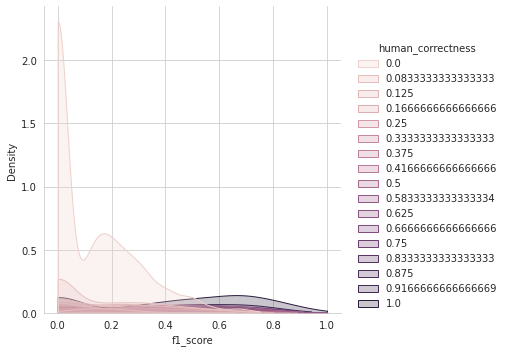

In [7]:
sns.displot(data=dev_df, x="f1_score", hue="human_correctness", kind="kde", fill=True, cut=0)

### Compute Pearson and Spearman Correlations

In [8]:
def collect_correlations(df, dataset=None, metric_cols=None, target_col=TARGET_COL):
    from scipy.stats import pearsonr, spearmanr

    if dataset is not None:
        df = df[df["dataset"] == dataset].copy()
    
    if metric_cols is None:
        metric_cols = df.select_dtypes("number").columns
    
    results = {}
    for metric_col in metric_cols:
        metric_corrs = {}
        
        correctness = df[target_col]
        metric_values = df[metric_col]
        
        pearson_val, p_value = pearsonr(correctness, metric_values)
        metric_corrs["pearson"] = pearson_val
        metric_corrs["pearson_pval"] = p_value

        spearman_val, p_value = spearmanr(correctness, metric_values)
        metric_corrs["spearman"] = spearman_val
        metric_corrs["spearman_pval"] = p_value
        
        # metric_corrs["dataset"] = dataset
        metric_corrs["n"] = len(df)
        results[metric_col] = metric_corrs
        
    return results


def get_all_correlations(df):
    unique_datasets = sorted(df.dataset.unique())

    correlations = {"all_datasets": collect_correlations(df)}
    correlations.update({
        d: collect_correlations(df, dataset=d) for d in unique_datasets
    })
    
    return correlations


# Sanity check (:
collect_correlations(dev_df);
get_all_correlations(dev_df)

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


{'all_datasets': {'human_correctness_original': {'pearson': 1.0,
   'pearson_pval': 0.0,
   'spearman': 1.0,
   'spearman_pval': 0.0,
   'n': 4009},
  'human_correctness': {'pearson': 1.0,
   'pearson_pval': 0.0,
   'spearman': 1.0,
   'spearman_pval': 0.0,
   'n': 4009},
  'exact_match': {'pearson': 0.02785433581031986,
   'pearson_pval': 0.07782701870676718,
   'spearman': 0.025262548882053704,
   'spearman_pval': 0.10975468251793481,
   'n': 4009},
  'meteor': {'pearson': 0.543264174610528,
   'pearson_pval': 1.1074087214518502e-306,
   'spearman': 0.5361934868693253,
   'spearman_pval': 2.637414521688378e-297,
   'n': 4009},
  'rouge1': {'pearson': 0.5652010583275225,
   'pearson_pval': 0.0,
   'spearman': 0.5387557872353683,
   'spearman_pval': 1.1193293831705143e-300,
   'n': 4009},
  'rouge2': {'pearson': 0.4147836604403485,
   'pearson_pval': 1.6148870489924668e-166,
   'spearman': 0.37463137075805375,
   'spearman_pval': 8.730744829119835e-134,
   'n': 4009},
  'rougeL': {'pea

In [9]:
dev_correlations = get_all_correlations(dev_df)

dev_corr_dfs = []
for dataset_name, correlations in dev_correlations.items():
    _df = pd.DataFrame.from_dict(correlations).T 
    dev_corr_dfs.append(_df)

dev_corr_dfs = pd.concat(dev_corr_dfs, keys=list(dev_correlations.keys()), axis=1)
dev_corr_dfs.to_csv(f"{METRICS_DIR}/dev_individual_correlations.csv")
dev_corr_dfs

all_datasets                           \
                                pearson   pearson_pval  spearman   
human_correctness_original     1.000000   0.000000e+00  1.000000   
human_correctness              1.000000   0.000000e+00  1.000000   
exact_match                    0.027854   7.782702e-02  0.025263   
meteor                         0.543264  1.107409e-306  0.536193   
rouge1                         0.565201   0.000000e+00  0.538756   
rouge2                         0.414784  1.614887e-166  0.374631   
rougeL                         0.570436   0.000000e+00  0.540206   
rougeLsum                      0.570436   0.000000e+00  0.540206   
bleurt                         0.623474   0.000000e+00  0.591277   
bert-score                     0.422590  2.008415e-173  0.415687   
bleu1                          0.458211  2.411723e-207  0.408451   
bleu2                          0.389773  1.346872e-145  0.356140   
bleu3                          0.313138   6.404673e-92  0.288984   
bleu4                          0.230285   2.112790e-49  0.215705   
bleu-precision0                0.478575  1.244443e-228  0.430928   
bleu-precision1                0.378778  5.862619e-137  0.354963   
bleu-precision2                0.298000   5.099725e-83  0.288403   
bleu-precision3                0.215788   1.881055e-43  0.215438   
precision                      0.478575  1.244443e-228  0.430928   
recall                         0.397042  1.712677e-151  0.399797   
f1_score                       0.487287  3.459094e-238  0.444884   
csi                            0.499551  4.048896e-252  0.445161   
num_edits                     -0.314251   1.353341e-92 -0.364977   
edit_score                    -0.142085   1.574646e-19 -0.374333   

                                                   cosmosqa                 \
                            spearman_pval       n   pearson   pearson_pval   
human_correctness_original   0.000000e+00  4009.0  1.000000   0.000000e+00   
human_correctness            0.000000e+00  4009.0  1.000000   0.000000e+00   
exact_match                  1.097547e-01  4009.0       NaN            NaN   
meteor                      2.637415e-297  4009.0  0.708732  2.826623e-105   
rouge1                      1.119329e-300  4009.0  0.715402  3.960762e-108   
rouge2                      8.730745e-134  4009.0  0.665687   1.223820e-88   
rougeL                      1.342110e-302  4009.0  0.723625  9.204665e-112   
rougeLsum                   1.342110e-302  4009.0  0.723625  9.204665e-112   
bleurt                       0.000000e+00  4009.0  0.841518  2.791025e-184   
bert-score                  2.622901e-167  4009.0  0.804586  2.796282e-156   
bleu1                       4.743625e-161  4009.0  0.657462   9.024142e-86   
bleu2                       3.416841e-120  4009.0  0.631208   3.409168e-77   
bleu3                        5.749807e-78  4009.0  0.524047   1.930493e-49   
bleu4                        2.029389e-43  4009.0  0.441262   6.521469e-34   
bleu-precision0             5.290887e-181  4009.0  0.658551   3.809196e-86   
bleu-precision1             2.340009e-119  4009.0  0.611681   2.483131e-71   
bleu-precision2              1.199383e-77  4009.0  0.496539   8.399777e-44   
bleu-precision3              2.588760e-43  4009.0  0.409294   5.715823e-29   
precision                   5.290887e-181  4009.0  0.658551   3.809196e-86   
recall                      9.113108e-154  4009.0  0.599156   8.798600e-68   
f1_score                    3.549311e-194  4009.0  0.655842   3.232279e-85   
csi                         1.914057e-194  4009.0  0.664138   4.313244e-88   
num_edits                   1.411694e-126  4009.0 -0.580631   8.236998e-63   
edit_score                  1.469588e-133  4009.0 -0.437297   2.860582e-33   

                                                            ...    quoref  \
                            spearman  spearman_pval      n  ...   pearson   
human_correctness_original  1.000000   0.000000e+00  683.0  ...  1.000000  

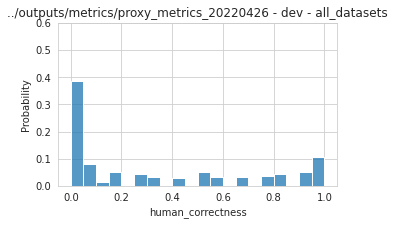

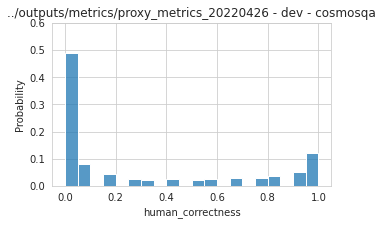

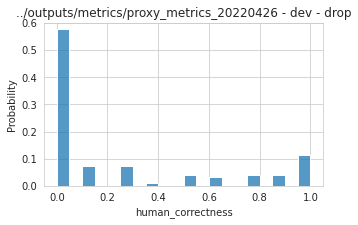

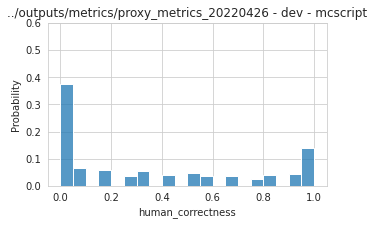

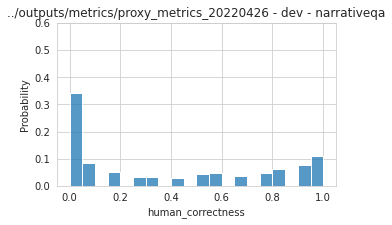

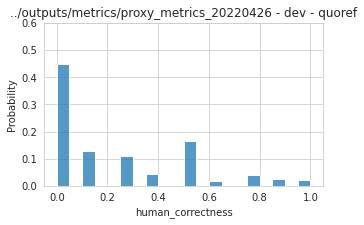

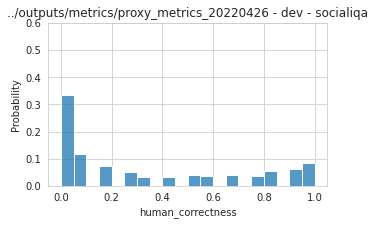

In [10]:
def plot_col_distribution(df, col, split, figsize=(5, 3), **kwargs):
    plt.figure(figsize=figsize)
    plt.title(f"{METRICS_DIR} - {split} - all_datasets")
    sns.histplot(data=df, x=col, **kwargs)
    plt.ylim(0, 0.6)
    plt.show()

    for dataset in sorted(df.dataset.unique()):
        plt.figure(figsize=figsize)
        plt.title(f"{METRICS_DIR} - {split} - {dataset}")
        sns.histplot(data=df[df["dataset"] == dataset], x=col, **kwargs)
        plt.ylim(0, 0.6)
        plt.show()


plot_col_distribution(dev_df, TARGET_COL, split="dev", binrange=(0, 1), bins=20, stat="probability")

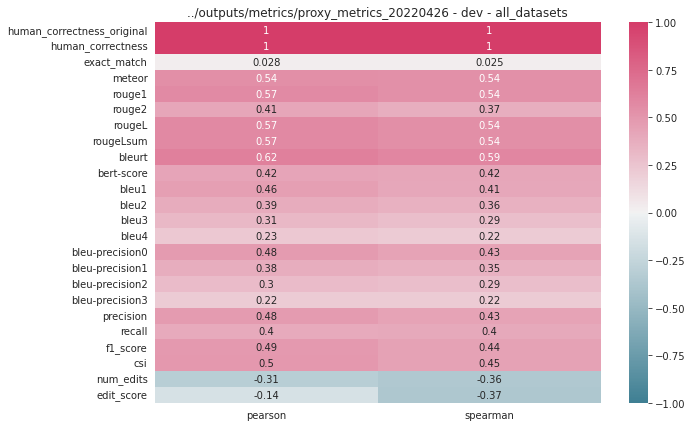

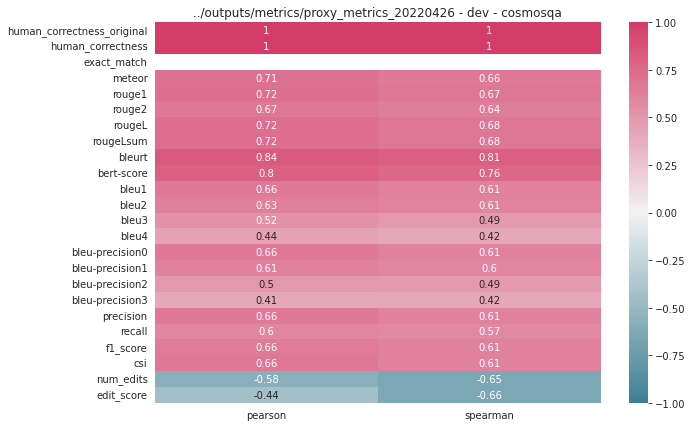

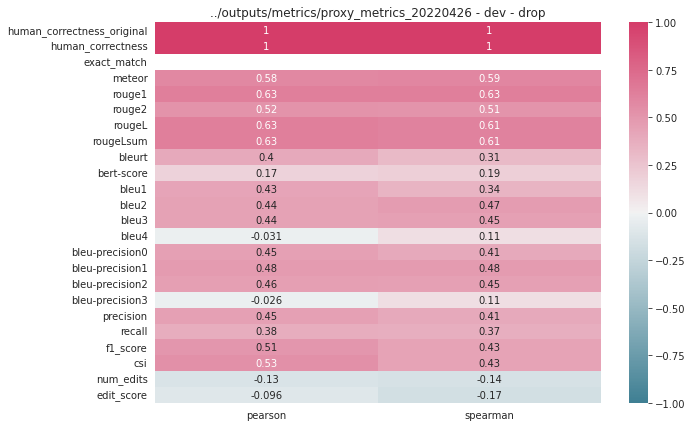

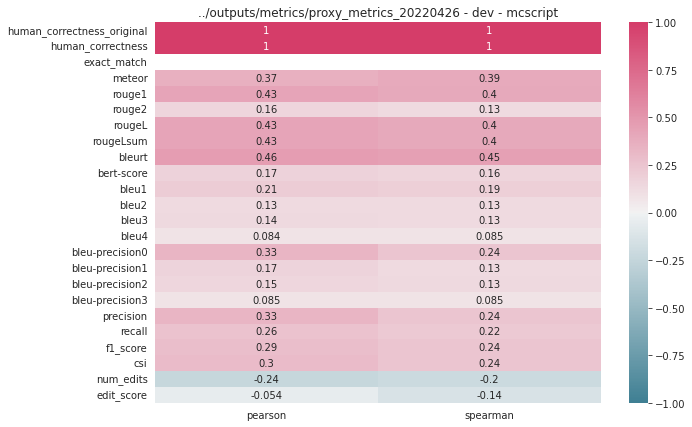

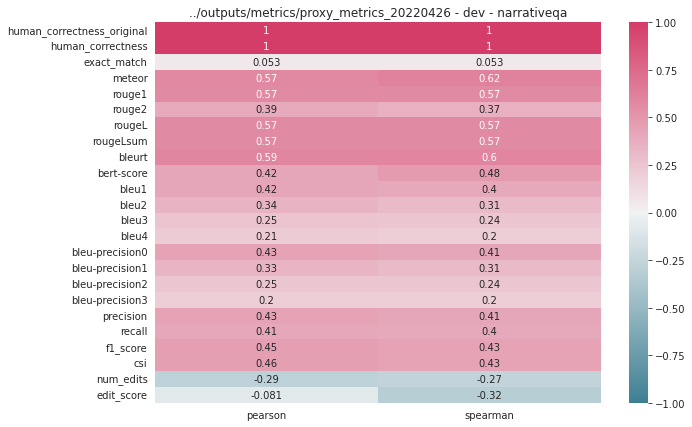

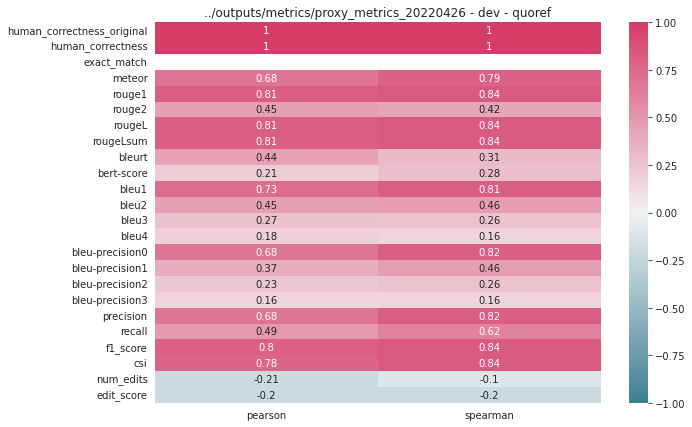

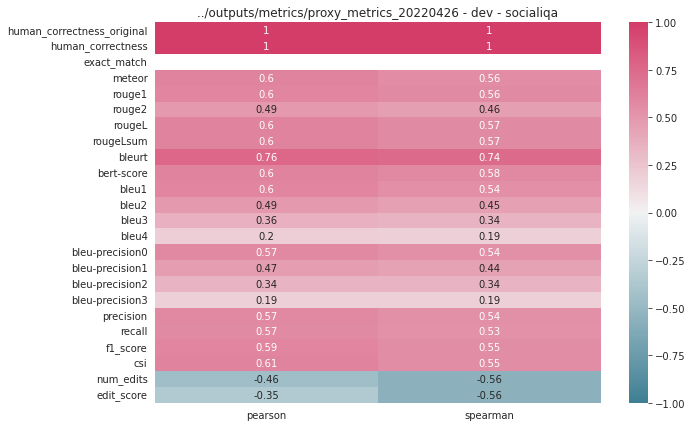

In [11]:
def plot_correlation_heatmaps(data_correlations: dict):
    for dataset, correlations in data_correlations.items():
        df = pd.DataFrame.from_dict(correlations).T    
        df = df.drop(["pearson_pval", "spearman_pval", "n"], axis=1)

        plt.figure(figsize=(10, 7))
        plt.title(f"{METRICS_DIR} - {SPLIT} - {dataset}")
        sns.heatmap(df, vmin=-1, vmax=1, cmap=DIV_CMAP, annot=True)
        plt.show()
        

plot_correlation_heatmaps(dev_correlations)

## Regression


In [12]:
TRAIN_FILEPATH = f"{METRICS_DIR}/train_all_datasets_metrics.csv.gz"

# Read original training set
train_df = pd.read_csv(TRAIN_FILEPATH, index_col=0)
print("Read dataset with", len(train_df), "examples from", TRAIN_FILEPATH)

# Define the columns to be all number types except the human correctness
METRIC_COLS = train_df.select_dtypes("number").columns
features = list(METRIC_COLS[2:])

# Target column will be the normalized human correctness
target = METRIC_COLS[1]
print("Target:", target, "\nFeatures:", features)

train_df.describe()

Read dataset with 31069 examples from ../outputs/metrics/proxy_metrics_20220426/train_all_datasets_metrics.csv.gz
Target: human_correctness 
Features: ['exact_match', 'meteor', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'bleurt', 'bert-score', 'bleu1', 'bleu2', 'bleu3', 'bleu4', 'bleu-precision0', 'bleu-precision1', 'bleu-precision2', 'bleu-precision3', 'precision', 'recall', 'f1_score', 'csi', 'num_edits', 'edit_score']


,human_correctness_original,human_correctness,exact_match,meteor,rouge1,rouge2,rougeL,rougeLsum,bleurt,bert-score,...,bleu-precision0,bleu-precision1,bleu-precision2,bleu-precision3,precision,recall,f1_score,csi,num_edits,edit_score
count,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000,...,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000,31069.000000
mean,2.441726,0.360432,0.025749,0.254618,0.297509,0.114169,0.291598,0.291598,-0.683481,0.882367,...,0.271054,0.101478,0.043957,0.019115,0.271054,0.302415,0.253980,0.174878,4.788825,1.618517
std,1.596674,0.399168,1.604473,0.272579,0.274482,0.214933,0.271489,0.271489,0.763747,0.051963,...,0.294849,0.214533,0.150594,0.100420,0.294849,0.317545,0.258699,0.201113,4.323865,2.809020
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.044297,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.289044,0.847184,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.666667
50%,2.000000,0.250000,0.000000,0.161290,0.250000,0.000000,0.250000,0.250000,-0.808630,0.873361,...,0.200000,0.000000,0.000000,0.000000,0.200000,0.222222,0.200000,0.111111,4.000000,1.000000
75%,4.000000,0.750000,0.000000,0.416667,0.500000,0.153846,0.500000,0.500000,-0.119696,0.912607,...,0.500000,0.000000,0.000000,0.000000,0.500000,0.500000,0.444444,0.285714,6.000000,1.333333
max,5.000000,1.000000,100.000000,0.999772,1.000000,1.000000,1.000000,1.000000,1.340944,1.000215,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,141.000000,110.000000


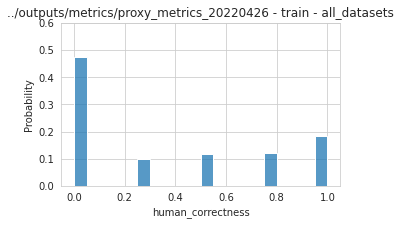

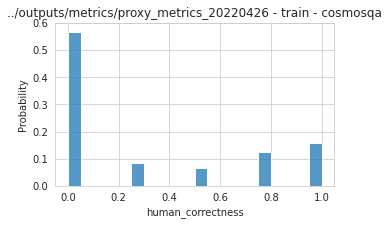

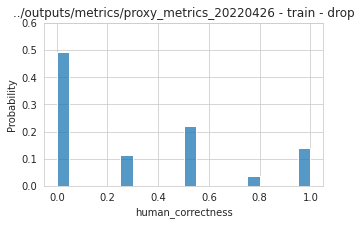

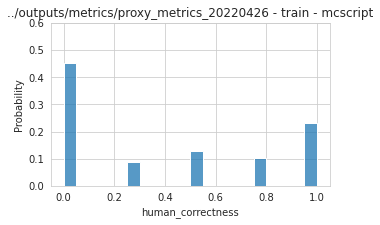

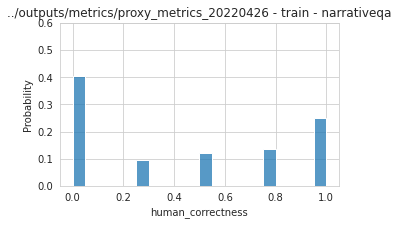

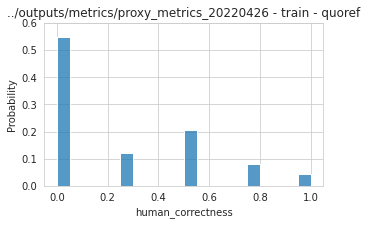

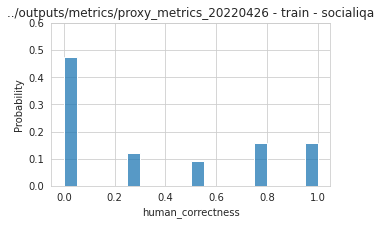

In [13]:
plot_col_distribution(train_df, target, split="train", binrange=(0, 1), bins=20, stat="probability")

### Regression

In [14]:
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics


def preprocess(data, scalers = None):
    data = data.copy()
    
    results = {}
    if scalers is not None:
        results = scalers
    
    for f in features:
        if scalers is None:
            scaler = StandardScaler()
            data[f] = scaler.fit_transform(data[f].values.reshape(-1, 1).copy())
            results[f] = scaler
        else:
            scaler = results[f]
            data[f] = scaler.transform(data[f].values.reshape(-1, 1))
            
    return data, results


def fit_model(data, estimator, dataset=None):

    if dataset is not None:
        data = data[data["dataset"] == dataset]
    
    print("Considering dataset with", len(data), "examples, spanning datasets:", data.dataset.unique())
    X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.20, random_state=78452, stratify=data[target])
    print(X_train.shape, X_test.shape)
    
    # Preprocessing data (since LR may be sensitive to it)
    X_train_prec, scalers = preprocess(X_train)
    X_test_prec, _ = preprocess(X_test, scalers=scalers)

    # Create estimator
    clf = estimator()
    clf.fit(X_train_prec, y_train)

    # Evaluate
    scores = clf.predict(X_test_prec)
    results = {
        "mse": metrics.mean_squared_error(y_test, scores),
        "r2": metrics.r2_score(y_test, scores),
        "pearson": pearsonr(scores, y_test)[0],
        "spearman": spearmanr(scores, y_test),
    }
    return clf, scalers, results


def eval_datasets(model, eval_datasets: dict, scalers: dict):
    eval_results = {}
    eval_scores = {}
    for dataset_name, dataset in eval_datasets.items():
        X, y = dataset[features], dataset[target]

        X_prec, _ = preprocess(X.copy(), scalers=scalers)

        scores = model.predict(X_prec)
        eval_results[dataset_name] = {
            "mse": metrics.mean_squared_error(y, scores),
            "r2": metrics.r2_score(y, scores),
            "pearson": pearsonr(scores, y)[0],
            "spearman": spearmanr(scores, y)[0],
        }
        eval_scores[dataset_name] = scores
        
    return eval_results, eval_scores


In [15]:
from sklearn.linear_model import LinearRegression

# Sanity check
lr, lr_scalers, valid_results = fit_model(train_df, LinearRegression, dataset="narrativeqa")
valid_results

Considering dataset with 7471 examples, spanning datasets: ['narrativeqa']
(5976, 22) (1495, 22)


{'mse': 0.1033028009237763,
 'r2': 0.4023469822405855,
 'pearson': 0.6346679931608183,
 'spearman': SpearmanrResult(correlation=0.6405167069912713, pvalue=2.0188743985225053e-173)}

In [16]:
from collections import defaultdict

# Unique datasets
unique_datasets = list(train_df.dataset.unique())

# Evaluation datasets
# includes all_datasets (macro eval), as well as individual datasets
dev_orig_datasets = {None: dev_df}
dev_orig_datasets.update({dataset: dev_df[dev_df.dataset == dataset] for dataset in unique_datasets})

models = {}
results_by_dataset = {}
for dataset_name in dev_orig_datasets.keys():
    print("Fitting model using", "all" if dataset_name is None else dataset_name, "datasets")
    model, model_scalers, valid_results = fit_model(train_df, LinearRegression, dataset=dataset_name)
    
    models[dataset_name] = model
    results, scores = eval_datasets(model, dev_orig_datasets, model_scalers)
    
    results_by_dataset[dataset_name] = results
    
    
    


def parse_table_results(results_by_dataset, filename, output_dir=METRICS_DIR):
    table_results = defaultdict(list)

    for train_dataset, test_values in results_by_dataset.items():

        for test_dataset, test_results in test_values.items():
            table_results["train_dataset"].append("all_datasets" if train_dataset is None else train_dataset)
            table_results["eval_dataset"].append("all_datasets" if test_dataset is None else test_dataset)

            for metric, metric_value in test_results.items():
                table_results[metric].append(metric_value)
            
    table_results = pd.DataFrame(table_results)
    table_results.to_csv((f"{output_dir}/{filename}.csv"))
    return table_results


table_results = parse_table_results(results_by_dataset, output_dir=METRICS_DIR, filename="dev_lr_correlations")
table_results

Fitting model using all datasets
Considering dataset with 31069 examples, spanning datasets: ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
(24855, 22) (6214, 22)
Fitting model using cosmosqa datasets
Considering dataset with 5033 examples, spanning datasets: ['cosmosqa']
(4026, 22) (1007, 22)
Fitting model using drop datasets
Considering dataset with 687 examples, spanning datasets: ['drop']
(549, 22) (138, 22)
Fitting model using mcscript datasets
Considering dataset with 7210 examples, spanning datasets: ['mcscript']
(5768, 22) (1442, 22)
Fitting model using narrativeqa datasets
Considering dataset with 7471 examples, spanning datasets: ['narrativeqa']
(5976, 22) (1495, 22)
Fitting model using quoref datasets
Considering dataset with 3259 examples, spanning datasets: ['quoref']
(2607, 22) (652, 22)
Fitting model using socialiqa datasets
Considering dataset with 7409 examples, spanning datasets: ['socialiqa']
(5927, 22) (1482, 22)


,train_dataset,eval_dataset,mse,r2,pearson,spearman
0,all_datasets,all_datasets,0.068746,0.510263,0.715596,0.697226
1,all_datasets,cosmosqa,0.052180,0.652688,0.849555,0.807096
2,all_datasets,drop,0.101270,0.247073,0.644830,0.648271
3,all_datasets,mcscript,0.095045,0.350694,0.608822,0.584252
4,all_datasets,narrativeqa,0.076225,0.491415,0.709606,0.723267
5,all_datasets,quoref,0.043526,0.418116,0.729917,0.699233
6,all_datasets,socialiqa,0.053462,0.600281,0.781097,0.757180
7,cosmosqa,all_datasets,0.094657,0.325674,0.627893,0.628917
8,cosmosqa,cosmosqa,0.037728,0.748885,0.867311,0.825657
9,cosmosqa,drop,0.183936,-0.367531,0.322426,0.399226


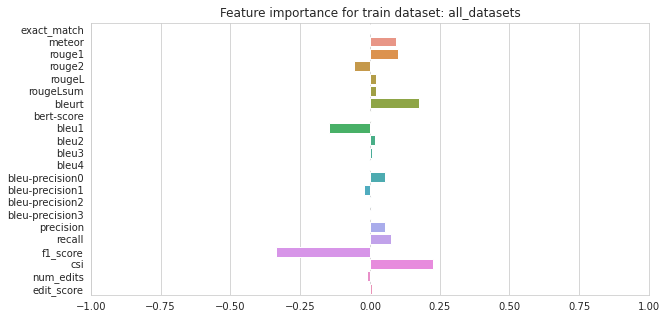

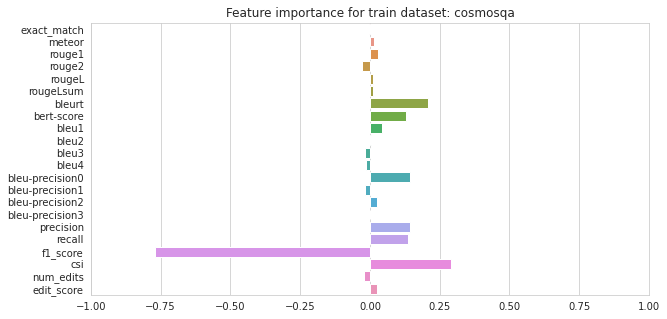

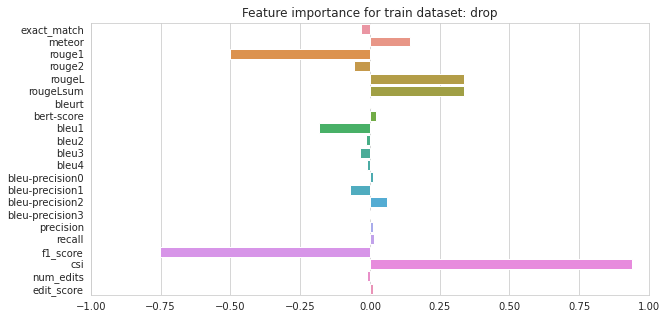

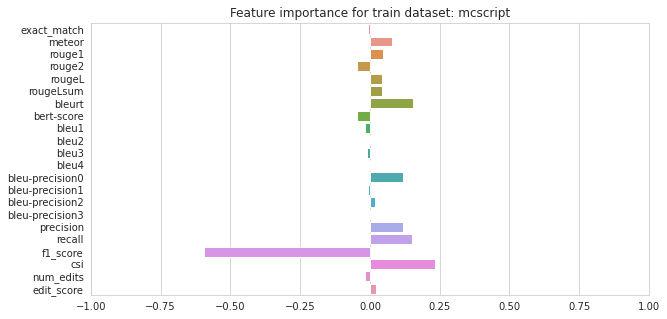

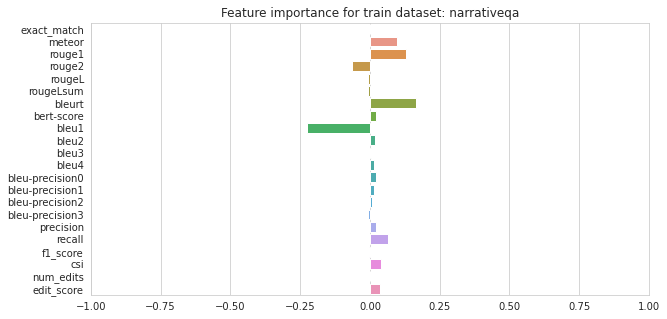

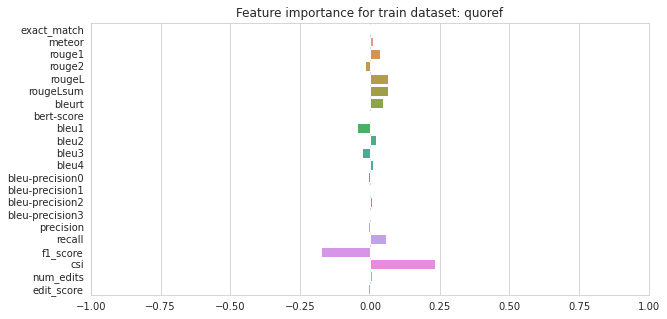

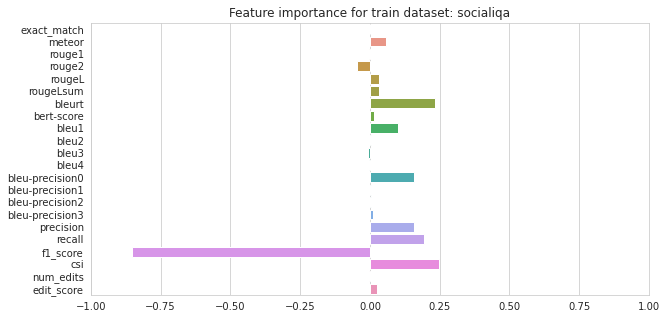

In [17]:
def plot_model_coeffs(models, train_dataset): 
    clf = models[train_dataset]
    plt.figure(figsize=(10, 5))
    plt.title(f"Feature importance for train dataset: {train_dataset if train_dataset is not None else 'all_datasets'}")
    sns.barplot(y=features, x=clf.coef_, orient="h")
    plt.xlim(-1, 1)
    plt.show()
    

for train_dataset in models.keys():
    plot_model_coeffs(models, train_dataset)


### Leave-one-out (LOO) Regression

In [18]:
from collections import defaultdict

# Unique datasets
_unique_datasets = list(train_df.dataset.unique())

# Evaluation datasets
# includes all_datasets (macro eval), as well as individual datasets
_dev_orig_datasets = {None: dev_df}
_dev_orig_datasets.update({dataset: dev_df[dev_df.dataset == dataset] for dataset in unique_datasets})

_models = {}
_results_by_dataset = {}
for _dataset_name in _dev_orig_datasets.keys():
    if _dataset_name is None: continue
    
    # Compute other dataset names except `_dataset_name`
    _remaining_datasets = [k for k in _dev_orig_datasets.keys() if k != _dataset_name]
    
    # Select subset of trainin data that does not include `_dataset_name`
    _train_remain_df = train_df[train_df.dataset.isin(_remaining_datasets)]
    _train_remain_name = f"all_except_{_dataset_name}"
    
    print("Fitting model on", _train_remain_name, f"with {len(_train_remain_df)} examples (instead of {len(train_df)})")

    _model, _model_scalers, _valid_results = fit_model(_train_remain_df, LinearRegression)
    _models[_train_remain_name] = _model
    _results, _scores = eval_datasets(_model, _dev_orig_datasets, _model_scalers)
    _results_by_dataset[_train_remain_name] = _results
    

parse_table_results(_results_by_dataset, "dev_lr_loo_correlations", METRICS_DIR)

Fitting model on all_except_cosmosqa with 26036 examples (instead of 31069)
Considering dataset with 26036 examples, spanning datasets: ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
(20828, 22) (5208, 22)
Fitting model on all_except_drop with 30382 examples (instead of 31069)
Considering dataset with 30382 examples, spanning datasets: ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
(24305, 22) (6077, 22)
Fitting model on all_except_mcscript with 23859 examples (instead of 31069)
Considering dataset with 23859 examples, spanning datasets: ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
(19087, 22) (4772, 22)
Fitting model on all_except_narrativeqa with 23598 examples (instead of 31069)
Considering dataset with 23598 examples, spanning datasets: ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
(18878, 22) (4720, 22)
Fitting model on all_except_quoref with 27810 examples (instead of 31069)
Considering dataset with 27810 examples, spanning datasets: ['cosmosqa

,train_dataset,eval_dataset,mse,r2,pearson,spearman
0,all_except_cosmosqa,all_datasets,0.070744,0.496024,0.710359,0.692148
1,all_except_cosmosqa,cosmosqa,0.061648,0.589673,0.844707,0.802490
2,all_except_cosmosqa,drop,0.107994,0.197085,0.632518,0.651026
3,all_except_cosmosqa,mcscript,0.094572,0.353925,0.603728,0.582077
4,all_except_cosmosqa,narrativeqa,0.075436,0.496682,0.709543,0.725338
5,all_except_cosmosqa,quoref,0.042738,0.428652,0.744990,0.719847
6,all_except_cosmosqa,socialiqa,0.055754,0.583145,0.776229,0.752292
7,all_except_drop,all_datasets,0.068822,0.509719,0.715499,0.696959
8,all_except_drop,cosmosqa,0.051825,0.655052,0.850700,0.808652
9,all_except_drop,drop,0.104057,0.226352,0.645081,0.647553


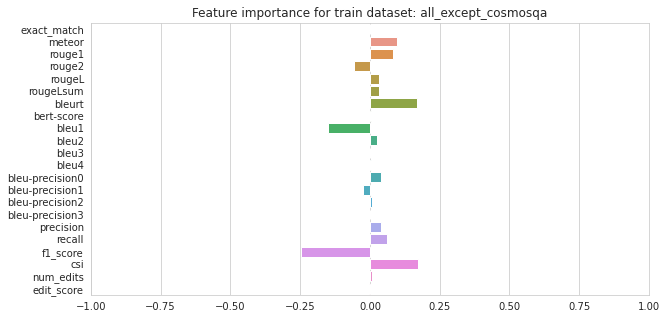

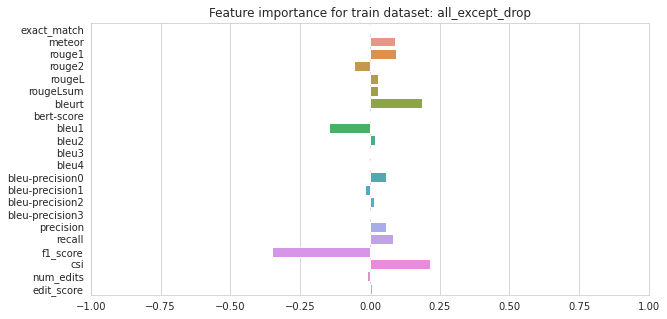

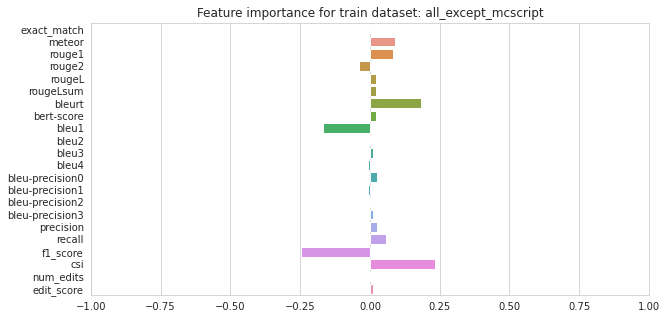

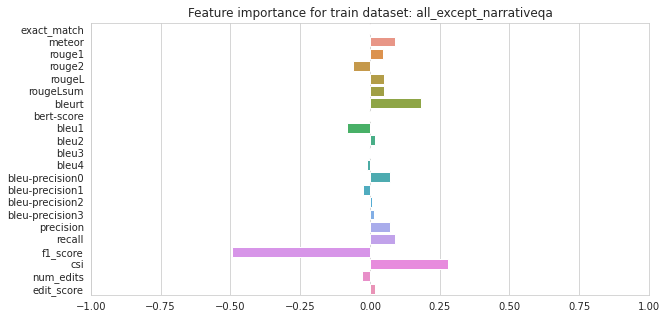

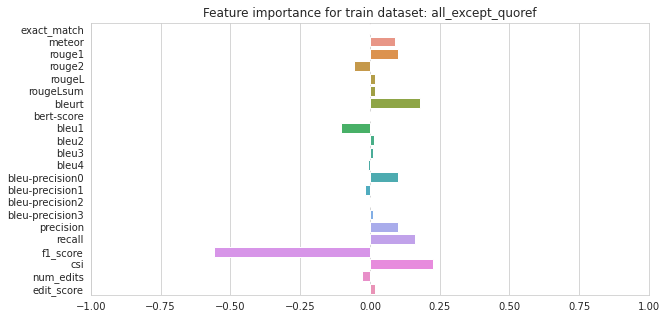

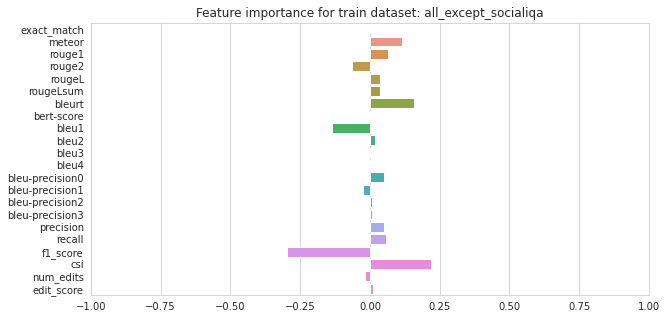

In [19]:
for train_dataset in _models.keys():
    plot_model_coeffs(_models, train_dataset)

### Principal Component Analysis

We've seen there is a large correlation between the different metrics.. In particular, it might explain the coefficients, we see in the image above. In the presence of redundancy, the model may be [non-identifiable](https://en.wikipedia.org/wiki/Identifiability), i.e., have two or more parameterizations that are observationally equivalent.

In this section of the notebook, we are interested in knowing whether there will be a set of orthogonal components that fully explain the model. 

In [20]:
def eval_datasets_with_pca(model, eval_datasets: dict, pca: dict):
    eval_results = {}
    eval_scores = {}
    for dataset_name, dataset in eval_datasets.items():
        X, y = dataset[features], dataset[target]

        X_prec = pca.transform(X.copy())

        scores = model.predict(X_prec)
        eval_results[dataset_name] = {
            "mse": metrics.mean_squared_error(y, scores),
            "r2": metrics.r2_score(y, scores),
            "pearson": pearsonr(scores, y)[0],
            "spearman": spearmanr(scores, y)[0],
        }
        eval_scores[dataset_name] = scores
    return eval_results, eval_scores

In [21]:
from sklearn.decomposition import PCA

In [22]:
data = train_df.copy()
print("Considering dataset with", len(data), "examples, spanning datasets:", data.dataset.unique())

X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.20, random_state=78452, stratify=data[target])
print(X_train.shape, X_test.shape)
    
# Preprocessing data (since LR may be sensitive to it)
# X_train_prec, scalers = preprocess(X_train)
# X_test_prec, _ = preprocess(X_test, scalers=scalers)


# Iterate over several components
eval_results = defaultdict(list)
_pca_models = {}
_pca = {}
for n in range(2, 20):
    print(X_train.shape, X_test.shape)
    print("Fitting PCA w/ n_components =", n)
    for seed in (123124, 1295532, 875843):
        # Create estimator
        pca = PCA(n_components=n, random_state=seed)
        X_train_transf = pca.fit_transform(X_train.copy())
        X_test_transf = pca.transform(X_test.copy())
        # print(X_train_transf.shape, X_test_transf.shape)

        # Fit LR on top of new representation
        lr = LinearRegression()
        lr.fit(X_train_transf, y_train)

        scores = lr.predict(X_test_transf)
        eval_results["n"].append(n)
        eval_results["seed"].append(n)
        eval_results["mse"].append(metrics.mean_squared_error(y_test, scores))
        eval_results["r2"].append(metrics.r2_score(y_test, scores))
        eval_results["pearson"].append(pearsonr(scores, y_test)[0])
        eval_results["spearman"].append(spearmanr(scores, y_test)[0])
        
        _pca[(n, seed)] = pca
        _pca_models[(n, seed)] = lr
        
eval_results = pd.DataFrame(eval_results)

Considering dataset with 31069 examples, spanning datasets: ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
(24855, 22) (6214, 22)
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 2
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 3
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 4
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 5
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 6
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 7
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 8
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 9
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 10
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 11
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 12
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 13
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 14
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 15
(24855, 22) (6214, 22)
Fitting PCA w/ n_components = 16
(24855, 22) (6214, 

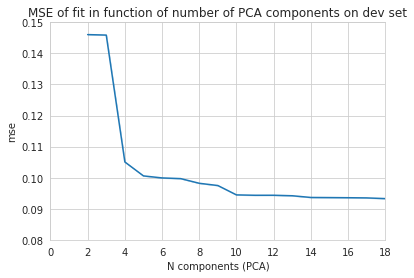

In [23]:
sns.lineplot(data=eval_results, x="n", y="mse")
plt.xlabel("N components (PCA)")
plt.title("MSE of fit in function of number of PCA components on dev set")
plt.xlim(0, 18)
plt.ylim(0.08, 0.15)
plt.show()

In [25]:
n_components, seed = 10, 1295532
model = _pca_models[(n_components, seed)]

# Unique datasets
unique_datasets = list(train_df.dataset.unique())

# Evaluation datasets
# includes all_datasets (macro eval), as well as individual datasets
dev_orig_datasets = {None: dev_df}
dev_orig_datasets.update({dataset: dev_df[dev_df.dataset == dataset] for dataset in unique_datasets})

results_by_dataset = {}
for dataset_name in dev_orig_datasets.keys():
    print("Fitting model using", "all" if dataset_name is None else dataset_name, "datasets")
    results, scores = eval_datasets_with_pca(
        model=model,
        pca=_pca[(n_components, seed)], 
        eval_datasets=dev_orig_datasets,
    )
    
    results_by_dataset[dataset_name] = results 

parse_table_results(results_by_dataset, f"dev_pca_{n_components}+lr_correlations", METRICS_DIR)

Fitting model using all datasets
Fitting model using cosmosqa datasets
Fitting model using drop datasets
Fitting model using mcscript datasets
Fitting model using narrativeqa datasets
Fitting model using quoref datasets
Fitting model using socialiqa datasets


,train_dataset,eval_dataset,mse,r2,pearson,spearman
0,all_datasets,all_datasets,0.071071,0.493700,0.703807,0.685821
1,all_datasets,cosmosqa,0.056376,0.624760,0.839080,0.797091
2,all_datasets,drop,0.108332,0.194567,0.605233,0.587230
3,all_datasets,mcscript,0.099048,0.323347,0.589872,0.567373
4,all_datasets,narrativeqa,0.077727,0.481397,0.703336,0.717304
5,all_datasets,quoref,0.041723,0.442220,0.728445,0.700006
6,all_datasets,socialiqa,0.054583,0.591905,0.776549,0.756082
7,cosmosqa,all_datasets,0.071071,0.493700,0.703807,0.685821
8,cosmosqa,cosmosqa,0.056376,0.624760,0.839080,0.797091
9,cosmosqa,drop,0.108332,0.194567,0.605233,0.587230
